<a href="https://colab.research.google.com/github/jjkim0/jjkim0/blob/main/fluid2d_pinn_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import os

In [ ]:
##
%cd /content/drive/MyDrive/mydata/
folder_paths = ['./Loss_History', './Checkpoints', 'data_save']

for folder_path in folder_paths:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


/content/drive/MyDrive/mydata


In [ ]:
# Define the PDE & BC residuals
@tf.function
def pde_loss(ndomain,ninlet,noutlet,nwall,X, model):
    # Calculate derivatives using tf.GradientTape
    X = tf.cast(X, dtype=tf.float32)
    x = X[:, 0:1]
    y = X[:, 1:2]
    # x = tf.convert_to_tensor(X[:, 0:1], dtype=tf.float32)
    # y = tf.convert_to_tensor(X[:, 1:2], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        y_pred = model(tf.stack([x[:,0], y[:,0]], axis=1))
        U = y_pred[:, 0:1]
        V = y_pred[:, 1:2]
        P = y_pred[:, 2:3]

        du_x = tape.gradient(U, x)
        du_y = tape.gradient(U, y)
        dv_x = tape.gradient(V, x)
        dv_y = tape.gradient(V, y)

    dp_x = tape.gradient(P, x)
    dp_y = tape.gradient(P, y)

    du_xx = tape.gradient(du_x, x)
    du_yy = tape.gradient(du_y, y)
    dv_xx = tape.gradient(dv_x, x)
    dv_yy = tape.gradient(dv_y, y)

    # Assemble the PDE equations
    pde_u = U * du_x + V * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = U * dv_x + V * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    # residuals
    rpde_u = tf.reduce_mean(tf.square(pde_u))
    rpde_v = tf.reduce_mean(tf.square(pde_v))
    rpde_cont = tf.reduce_mean(tf.square(pde_cont))
    # rpde_u = tf.sqrt(rpde_u)
    # rpde_v = tf.sqrt(rpde_v)
    # rpde_cont = tf.sqrt(rpde_cont)

    # BC residuals

    # inlet
    bc_in_x = tf.reduce_mean(tf.square(U[ndomain:ndomain+ninlet] - u_in))
    bc_in_y = tf.reduce_mean(tf.square(V[ndomain:ndomain+ninlet]))
    # bc_in_x = tf.sqrt(bc_in_x)
    # bc_in_y = tf.sqrt(bc_in_y)
    bc_in = bc_in_x + bc_in_y

    # outlet
    bc_out_p = tf.reduce_mean(tf.square(P[ndomain+ninlet:ndomain+ninlet+noutlet]))
    bc_out_v = tf.reduce_mean(tf.square(V[ndomain+ninlet:ndomain+ninlet+noutlet]))
    # bc_out_p = tf.sqrt(bc_out_p)
    # bc_out_v = tf.sqrt(bc_out_v)
    bc_out = bc_out_p + bc_out_v

    # wall
    bc_wall_u = tf.reduce_mean(tf.square(U[ndomain+ninlet+noutlet:ndomain+ninlet+noutlet+nwall]))
    bc_wall_v = tf.reduce_mean(tf.square(V[ndomain+ninlet+noutlet:ndomain+ninlet+noutlet+nwall]))
    # bc_wall_u = tf.sqrt(bc_wall_u)
    # bc_wall_v = tf.sqrt(bc_wall_v)
    bc_wall = bc_wall_u + bc_wall_v

    del tape

    return [rpde_u, rpde_v, rpde_cont, bc_in, bc_out, bc_wall]


# Define the loss function and optimizer
@tf.function
def loss_fn(ndomain,ninlet,noutlet,nwall,X, model):
    pde_residuals = pde_loss(ndomain,ninlet,noutlet,nwall,X, model)
    # ... (add boundary condition residuals to the loss)
    return tf.reduce_sum(pde_residuals)


# save & load model
def save_checkpoint(checkpoint_prefix, model, optimizer, epoch):
  """Saves the model and optimizer state to a checkpoint file.
  """
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
  # checkpoint_path = os.path.join(checkpoint_prefix, f"checkpoint-{epoch}")
  checkpoint_path = os.path.join(checkpoint_prefix, "checkpoint")
  checkpoint.save(checkpoint_path)

def load_checkpoint(checkpoint_prefix, model, optimizer, epoch):
  """Loads the model and optimizer state from a checkpoint file.
  """
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
  # checkpoint_path = os.path.join(checkpoint_prefix, f"checkpoint-{epoch}-1")
  checkpoint_path = os.path.join(checkpoint_prefix, "checkpoint-1")
  checkpoint.restore(checkpoint_path).expect_partial()  # Ignore warnings about missing variables



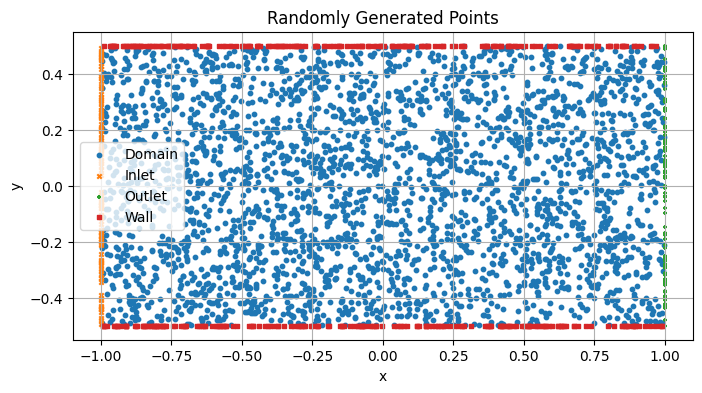

In [ ]:
# Generate training data
# x_domain, x_wall, x_inlet, x_outlet 을 생성하고 x_train 으로 합치기
# geometry generation - corner point 문제 고려 (gap 사용)
ndomain=3000
ninlet=100
noutlet=100
nwall=400

# 매개변수 설정
l = 2
d = 1
num_domain = ndomain
num_inlet = ninlet
num_outlet = noutlet
num_wall = nwall

# 영역 내부 점 생성 (x_domain)
gap = 0.001
x_domain = np.zeros((num_domain, 2))
x_domain = np.random.rand(num_domain, 2)  # 0~1 사이의 난수 생성
x_domain[:, 0] = x_domain[:, 0] * (l-2*gap) - (l / 2-gap)  # x 좌표: -l/2 ~ l/2
x_domain[:, 1] = x_domain[:, 1] * (d-2*gap) - (d / 2-gap)  # y 좌표: -d/2 ~ d/2


# Inlet 경계 점 생성 (x_inlet)
x_inlet = np.zeros((num_inlet, 2))
x_inlet[:, 0] = -l / 2  # x 좌표: -l/2
x_inlet[:, 1] = np.random.rand(num_inlet) * d - d / 2  # y 좌표: -d/2 ~ d/2

# Outlet 경계 점 생성 (x_outlet)
x_outlet = np.zeros((num_outlet, 2))
x_outlet[:, 0] = l / 2  # x 좌표: l/2
x_outlet[:, 1] = np.random.rand(num_outlet) * d - d / 2  # y 좌표: -d/2 ~ d/2

# Wall 경계 점 생성 (x_wall)
x_wall = np.zeros((num_wall, 2))
x_wall[: num_wall // 2, 0] = np.random.rand(num_wall // 2) * (l-2*gap) - (l / 2-gap)  # x 좌표: -l/2 ~ l/2 (절반)
x_wall[: num_wall // 2, 1] = -d / 2  # y 좌표: -d/2 (절반)
x_wall[num_wall // 2 :, 0] = np.random.rand(num_wall // 2) * (l-2*gap) - (l / 2-gap)  # x 좌표: -l/2 ~ l/2 (나머지 절반)
x_wall[num_wall // 2 :, 1] = d / 2  # y 좌표: d/2 (나머지 절반)

# Combine all points into x_total
X_train = np.concatenate([x_domain, x_inlet, x_outlet, x_wall], axis=0)

# Scatter plot
plt.figure(figsize=(8, 4))  # Adjust figure size if needed

plt.scatter(x_domain[:, 0], x_domain[:, 1], label='Domain', s=10, marker='o')  # Domain points
plt.scatter(x_inlet[:, 0], x_inlet[:, 1], label='Inlet', s=10, marker='x')    # Inlet points
plt.scatter(x_outlet[:, 0], x_outlet[:, 1], label='Outlet', s=10, marker='+')  # Outlet points
plt.scatter(x_wall[:, 0], x_wall[:, 1], label='Wall', s=10, marker='s')      # Wall points

plt.xlabel('x')
plt.ylabel('y')
plt.title('Randomly Generated Points')
plt.legend()
plt.grid(True)

plt.show()



Weights and optimizer restored from saved files
Restart traning


Epoch 0, Loss: 0.044499196112155914
Epoch 1000, Loss: 0.07220593094825745
Epoch 2000, Loss: 0.05627543479204178
Epoch 3000, Loss: 0.04855800420045853
Epoch 4000, Loss: 0.04552483186125755
Epoch 5000, Loss: 0.040669187903404236
Epoch 6000, Loss: 0.037494122982025146
Epoch 7000, Loss: 0.037752702832221985
Epoch 8000, Loss: 0.034255288541316986
Epoch 9000, Loss: 0.03462934494018555
Epoch 10000, Loss: 0.035132043063640594
Epoch 11000, Loss: 0.03344156593084335
Epoch 12000, Loss: 0.043026551604270935
Epoch 13000, Loss: 0.038552410900592804
Epoch 14000, Loss: 0.03143620863556862
Epoch 15000, Loss: 0.04075773432850838
Epoch 16000, Loss: 0.04032430797815323
Epoch 17000, Loss: 0.027958732098340988
Epoch 18000, Loss: 0.03030141070485115
Epoch 19000, Loss: 0.030229412019252777
Epoch 20000, Loss: 0.041787825524806976
Epoch 21000, Loss: 0.07251115888357162
Epoch 22000, Loss: 0.027276432141661644
Epoch 23000, Loss: 0.06268763542175293
Epoch 24000, Loss: 0.03343483805656433
Epoch 25000, Loss: 0.02602

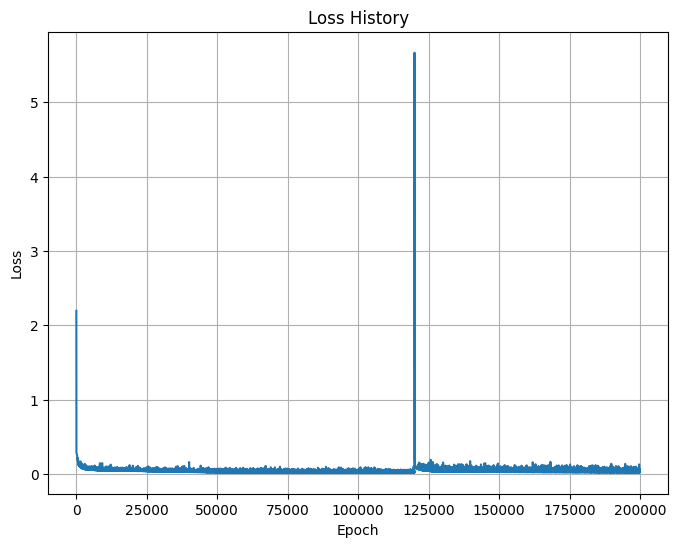

Best model saved at epoch 79767 with loss 0.022157926112413406
CPU times: user 7h 43min 19s, sys: 36min, total: 8h 19min 19s
Wall time: 1h 52min 40s


In [ ]:
%%time

Restart = 1   # 1: restart, 0: new training


# Training loop
epochs = 80000

# Properties
rho = 1
mu = 1
u_in = 1




# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(2,)),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(3)  # Output layer for u, v, p
])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)



##
if Restart > 0:
    pre_ep = epochs
    # checkpoint save & load 시 epochs 번호를 사용하고 (현재 사용하지 않음)
    # restart 시 epochs의 값을 변경한 경우 pre_ep의 값을 변경해 줘야 함
    load_checkpoint("./Checkpoints",model, optimizer,pre_ep)
    # history 불러오기 삽입
    histt = sio.loadmat("./Loss_History/loss_history.mat")
    hist=histt['losses']
    loss_history=hist[0].tolist()
    loss_history = [np.float32(x) for x in loss_history]

    print(f"Weights and optimizer restored from saved files")
    print('Restart traning')
    # start_epoch = 0  # 이전 학습 epoch 수 무시 - 의미없음

else:
    # start_epoch = 0  # 이전 학습 epoch 수
    print("Start training")
    loss_history = []  # Initialize an empty list to store loss values

best_loss = float('inf')  # Initialize best_loss to infinity
best_epoch = 0  # Initialize best_epoch to 0

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Y_pred = model(X_train)
        loss = loss_fn(ndomain,ninlet,noutlet,nwall,X_train,model)

    lossf=loss.numpy() # Convert tensor to NumPy array and extract value
    loss_history.append(lossf)  # Append the current loss to the list
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # ... (print loss, save checkpoints, etc.)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    # 최소 로스에 대해 저장하고 이를 이용하는 것을 고려
    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch
        model.save_weights('./data_save/best_model.weights.h5')  # Save the model weights

save_checkpoint("./Checkpoints", model, optimizer, epochs)
history = {"losses": loss_history}
sio.savemat("./Loss_History/loss_history.mat", history)

# ... (Visualization and post-processing)
# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f"Best model saved at epoch {best_epoch} with loss {best_loss.numpy()}")

By passing the model explicitly to pde_loss and loss_fn, the tf.GradientTape can correctly track the operations on the model's trainable variables during the loss calculation. This will allow the optimizer to calculate the necessary gradients and update the model's weights.

@tf.function은 TensorFlow에서 Eager Execution 모드에서 실행되는 Python 함수를 TensorFlow 그래프로 변환하여 실행하는 데코레이터입니다. 이를 통해 코드의 성능을 향상시킬 수 있는 몇 가지 이점이 있습니다:

그래프 최적화: @tf.function은 함수를 그래프로 변환하면서 TensorFlow의 그래프 최적화기를 사용하여 연산을 재정렬하고 불필요한 연산을 제거합니다. 이는 특히 복잡한 계산이 포함된 함수에서 성능 향상에 도움이 됩니다.

AutoGraph: @tf.function은 AutoGraph 기능을 사용하여 Python 제어 흐름 (if 문, for 루프 등)을 TensorFlow 연산으로 변환합니다. 이를 통해 Python 코드를 수정하지 않고도 TensorFlow 그래프의 이점을 활용할 수 있습니다.

XLA 컴파일: @tf.function으로 데코레이션된 함수는 XLA (Accelerated Linear Algebra) 컴파일을 통해 더욱 최적화될 수 있습니다. XLA는 TensorFlow 그래프를 특정 하드웨어 (CPU, GPU, TPU)에 맞게 컴파일하여 실행 속도를 향상시킵니다.

이 코드에서 @tf.function을 적용할 수 있는 부분은 pde_loss 함수와 loss_fn 함수입니다. 이 함수들은 PDE 및 BC 잔차를 계산하는 데 사용되며, 반복적으로 호출됩니다. 따라서 이 함수들을 @tf.function으로 데코레이션하면 그래프 최적화, AutoGraph, XLA 컴파일의 이점을 활용하여 코드의 실행 속도를 향상시킬 수 있습니다.

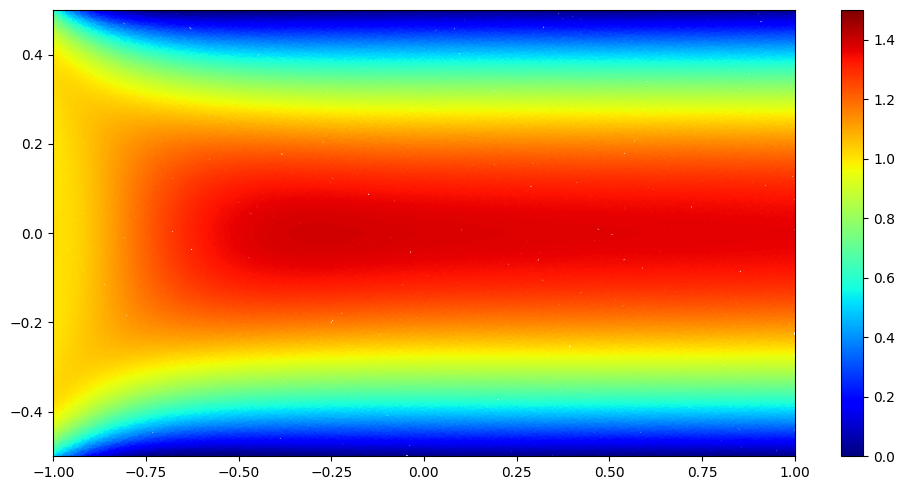

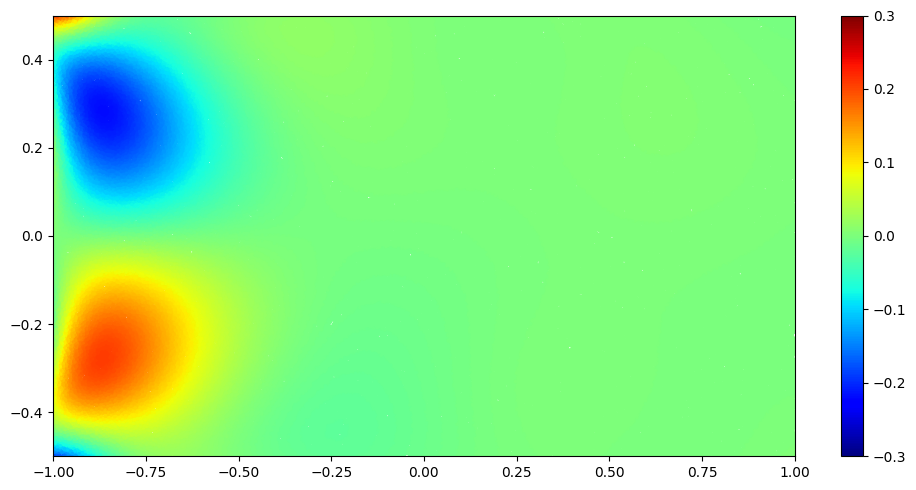

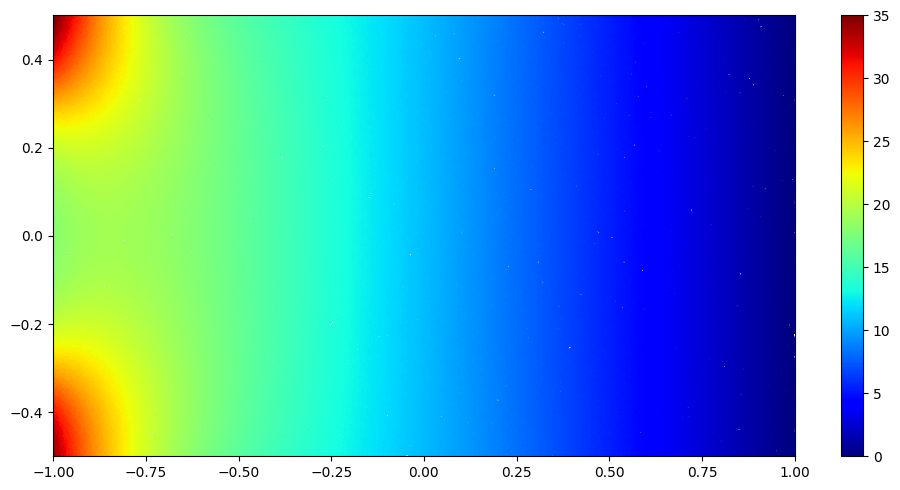

In [ ]:
# Load the best model weights
model.load_weights('./data_save/best_model.weights.h5')

num_points = 300000

points = []
while len(points) < num_points:
    x = np.random.uniform(-l/2, l/2)
    y = np.random.uniform(-d/2, d/2)
    points.append([x, y])


# points 리스트를 TensorFlow 텐서로 변환
domain_points = tf.convert_to_tensor(points)

y=model(domain_points)

plt.figure(figsize=(10,5))
plt.scatter(domain_points[:, 0:1], domain_points[:, 1:2], 2, y[:, 0:1],cmap='jet')
plt.colorbar()
plt.clim([0,1.5])
plt.xlim((-1,1))
plt.ylim((-.5,.5))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(domain_points[:, 0:1], domain_points[:, 1:2], 2, y[:, 1:2],cmap='jet')
plt.colorbar()
plt.clim([-0.3,0.3])
plt.xlim((-1,1))
plt.ylim((-.5,.5))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(domain_points[:, 0:1], domain_points[:, 1:2], 2, y[:, 2:3],cmap='jet')
plt.colorbar()
plt.clim([0,35])
plt.xlim((-1,1))
plt.ylim((-.5,.5))
plt.tight_layout()
plt.show()

Shape of x_total: (3600, 2)


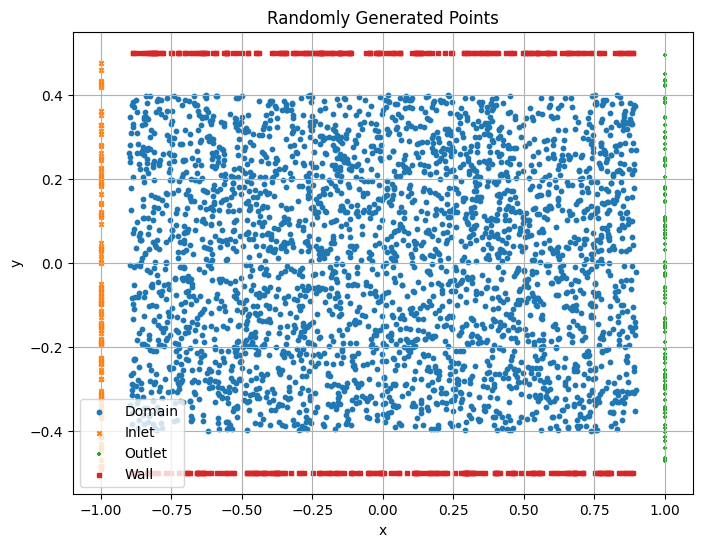

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# 매개변수 설정
l = 2
d = 1
num_domain = 3000
num_inlet = 100
num_outlet = 100
num_wall = 400

# 영역 내부 점 생성 (x_domain)
gap = 0.1
x_domain = np.zeros((num_domain, 2))
x_domain = np.random.rand(num_domain, 2)  # 0~1 사이의 난수 생성
x_domain[:, 0] = x_domain[:, 0] * (l-2*gap) - (l / 2-gap)  # x 좌표: -l/2 ~ l/2
x_domain[:, 1] = x_domain[:, 1] * (d-2*gap) - (d / 2-gap)  # y 좌표: -d/2 ~ d/2

# x_domain = []
# while len(x_domain) < num_domain:
#     x = np.random.uniform(-l / 2 + 1e-6, l / 2 - 1e-6)  # 경계에서 약간 떨어진 범위에서 난수 생성
#     y = np.random.uniform(-d / 2 + 1e-6, d / 2 - 1e-6)  # 경계에서 약간 떨어진 범위에서 난수 생성
#     x_domain.append([x, y])

# x_domain = np.array(x_domain)  # 리스트를 NumPy 배열로 변환

# Inlet 경계 점 생성 (x_inlet)
x_inlet = np.zeros((num_inlet, 2))
x_inlet[:, 0] = -l / 2  # x 좌표: -l/2
x_inlet[:, 1] = np.random.rand(num_inlet) * d - d / 2  # y 좌표: -d/2 ~ d/2

# Outlet 경계 점 생성 (x_outlet)
x_outlet = np.zeros((num_outlet, 2))
x_outlet[:, 0] = l / 2  # x 좌표: l/2
x_outlet[:, 1] = np.random.rand(num_outlet) * d - d / 2  # y 좌표: -d/2 ~ d/2

# Wall 경계 점 생성 (x_wall)
x_wall = np.zeros((num_wall, 2))
x_wall[: num_wall // 2, 0] = np.random.rand(num_wall // 2) * (l-2*gap) - (l / 2-gap)  # x 좌표: -l/2 ~ l/2 (절반)
x_wall[: num_wall // 2, 1] = -d / 2  # y 좌표: -d/2 (절반)
x_wall[num_wall // 2 :, 0] = np.random.rand(num_wall // 2) * (l-2*gap) - (l / 2-gap)  # x 좌표: -l/2 ~ l/2 (나머지 절반)
x_wall[num_wall // 2 :, 1] = d / 2  # y 좌표: d/2 (나머지 절반)

# Combine all points into x_total
x_total = np.concatenate([x_domain, x_inlet, x_outlet, x_wall], axis=0)

# Print the shape of x_total to verify
print("Shape of x_total:", x_total.shape)


# Scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

plt.scatter(x_domain[:, 0], x_domain[:, 1], label='Domain', s=10, marker='o')  # Domain points
plt.scatter(x_inlet[:, 0], x_inlet[:, 1], label='Inlet', s=10, marker='x')    # Inlet points
plt.scatter(x_outlet[:, 0], x_outlet[:, 1], label='Outlet', s=10, marker='+')  # Outlet points
plt.scatter(x_wall[:, 0], x_wall[:, 1], label='Wall', s=10, marker='s')      # Wall points

plt.xlabel('x')
plt.ylabel('y')
plt.title('Randomly Generated Points')
plt.legend()
plt.grid(True)

plt.show()

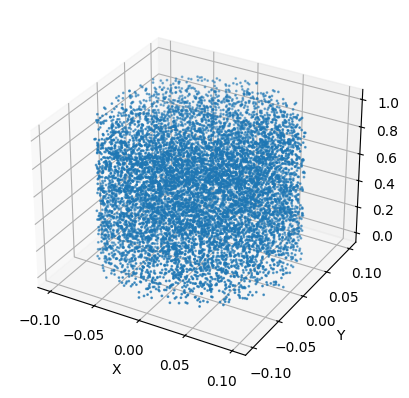

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 반지름, 길이, 점 개수 설정
R = 0.1
L = 1
num_points = 10000

# 랜덤 포인트 생성
# 극좌표를 사용하여 원기둥 내부의 점을 생성합니다.
theta = np.random.uniform(0, 2*np.pi, num_points)
r = R * np.sqrt(np.random.uniform(0, 1, num_points))
x = r * np.cos(theta)
y = r * np.sin(theta)
z = np.random.uniform(0, L, num_points)

# 3차원 scatter plot 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1)  # s는 점의 크기를 나타냅니다.

# 축 레이블 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 플롯 출력
plt.show()

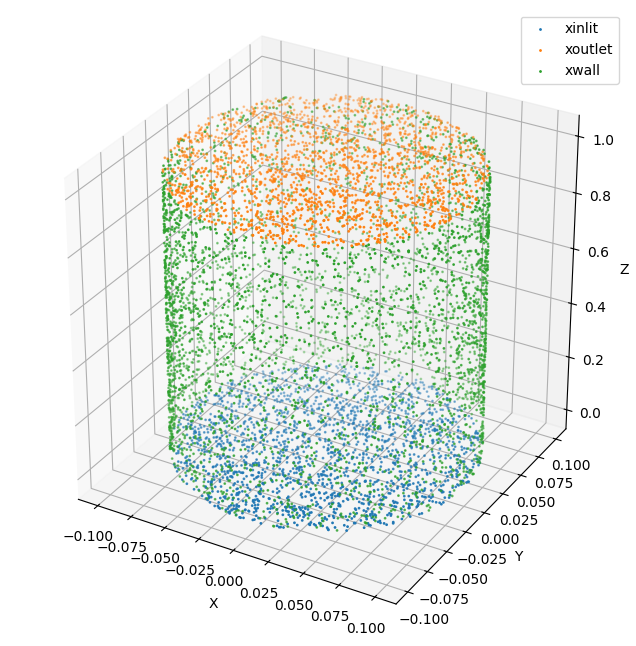

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 반지름, 길이, 점 개수 설정
R = 0.1
L = 1
num_domain = 10000
num_inlet = 2000
num_outlet = 2000
num_wall = 4000

# 도메인 내부 점 생성 (xdomain)
theta = np.random.uniform(0, 2*np.pi, num_domain)
r = R * np.sqrt(np.random.uniform(0, 1, num_domain))
x = r * np.cos(theta)
y = r * np.sin(theta)
z = np.random.uniform(0, L, num_domain)
xdomain = np.stack([x, y, z], axis=1)

# Inlet (z=0) 점 생성 (xinlit)
theta = np.random.uniform(0, 2*np.pi, num_inlet)
r = R * np.sqrt(np.random.uniform(0, 1, num_inlet))
x = r * np.cos(theta)
y = r * np.sin(theta)
z = np.zeros(num_inlet)
xinlit = np.stack([x, y, z], axis=1)

# Outlet (z=1) 점 생성 (xoutlet)
theta = np.random.uniform(0, 2*np.pi, num_outlet)
r = R * np.sqrt(np.random.uniform(0, 1, num_outlet))
x = r * np.cos(theta)
y = r * np.sin(theta)
z = np.ones(num_outlet)
xoutlet = np.stack([x, y, z], axis=1)

# Wall (옆면) 점 생성 (xwall)
theta = np.random.uniform(0, 2*np.pi, num_wall)
x = R * np.cos(theta)
y = R * np.sin(theta)
z = np.random.uniform(0, L, num_wall)
xwall = np.stack([x, y, z], axis=1)

# 3차원 scatter plot 생성
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xdomain[:, 0], xdomain[:, 1], xdomain[:, 2], s=1, label='xdomain')
ax.scatter(xinlit[:, 0], xinlit[:, 1], xinlit[:, 2], s=1, label='xinlit')
ax.scatter(xoutlet[:, 0], xoutlet[:, 1], xoutlet[:, 2], s=1, label='xoutlet')
ax.scatter(xwall[:, 0], xwall[:, 1], xwall[:, 2], s=1, label='xwall')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# z 축 길이를 1/5 배로 조정
ax.set_box_aspect((np.ptp(x), np.ptp(y), 0.2*np.ptp(z)))

plt.show()